In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%run initialize_interactivity

In [2]:
RAW_DATA_PATH = './nation_data.xlsx'
RANDOM_SEED = 0

In [3]:
def load_data(path):
    
    ''' Load and preprocess the data '''
    
    # create dataframe
    raw_data = pd.read_excel(path)

    # drop unwated columns
    raw_data.drop(['8 - Structure Number'],axis=1,inplace=True)

    # drop columns with nan
    raw_data.dropna(axis=1,how='all',inplace=True)

    # fill nan values with 0
    raw_data.fillna(value=0, inplace=True)

    # replace 0 values with error code
    replace = {'58 - Deck': {0 : '99 - Null Value'}}
    raw_data.replace(to_replace=replace, inplace=True)

    # factorize categorical variables and create dict of preprocessed data
    cat_data = {}
    data_dict = {}
    for i,x in enumerate(raw_data.dtypes.values): 
        col = raw_data.columns[i] 
        if x == object:        
            cat_data[col] = pd.factorize(raw_data[col])
            data_dict[col] = cat_data[col][0]
        else:
            data_dict[col] = raw_data[col]
            
    data = pd.DataFrame(data_dict)
    
    return data, cat_data

In [4]:
def get_test_train(data, test_size = 0.4, RANDOM_SEED = 0, verbose = False):
    
    ''' Get train and test datasets '''
    
    # extract features and targets
    features = data.drop(['58 - Deck'],axis=1)
    target = data['58 - Deck']

    # get train/test split
    train_X, test_X, train_y, test_y = train_test_split(features, target, test_size=test_size, random_state=RANDOM_SEED)
    
    # print sizes
    if verbose:
        print('Size of training set:', len(train_y))
        print('Size of test set:',len(test_y))
    
    return train_X, test_X, train_y, test_y

In [5]:
def get_cross_val(test_X, test_y, test_size = 0.5, RANDOM_SEED = 0, verbose = False):
    
    ''' Get cross-val and test datasets '''
    
    # get train/test split
    test_X, cross_X, test_y, cross_y = train_test_split(test_X, test_y, test_size=test_size, random_state=RANDOM_SEED)
    
    # print sizes
    if verbose:
        print('Size of cross-validation set:',len(cross_y))
        print('New size of test set:', len(test_y))

    return test_X, cross_X, test_y, cross_y

In [6]:
def train_clf(train_X, train_y, 
              n_estimators = 10, criterion = 'gini', 
              max_features = 'auto', max_depth = None, 
              n_jobs = 2, verbose = False):
    
    ''' Create and train  Random Forest Classifier with given tuning parameters '''
    
    # create random forest classifier
    clf = RandomForestClassifier(n_estimators = n_estimators, 
                                 criterion = criterion,
                                 max_features = max_features, 
                                 max_depth = max_depth, 
                                 n_jobs = n_jobs)
    
    # train the classifier
    clf.fit(train_X, train_y)
    
    # print train accuracy
    train_accuracy = round(accuracy_score(train_y, clf.predict(train_X)),4)
    
    # print train accuracy
    if verbose:
        print(f'Train Accuracy = {train_accuracy}') #train
    
    return clf

In [7]:
def test_clf(test_X, test_y, clf, cat_data, verbose=False):
    
    ''' Test the Random Forest Classifier '''
    
    # get predictions
    predict = clf.predict(test_X)
    
    # convert target names back to condition indices
    cond_index = cat_data['58 - Deck'][1][predict]
    
    # precision, recall and f1 scores
    precision = precision_score(test_y, predict, average='weighted')
    recall  =recall_score(test_y, predict, average='weighted')
    f1 = f1_score(test_y, predict, average='weighted')
    
    # print scores
    if verbose:
        print("Precision: %1.5f" % precision)
        print("Recall: %1.5f" % recall)
        print("F1: %1.5f\n" % f1)
    
    return predict, cond_index, precision, recall, f1

In [8]:
def get_feature_importances(top = 10, plot = False, df = False):
    
    importances = sorted((val,i) for i,val in enumerate(clf.feature_importances_))
    importances = pd.DataFrame(importances, columns=["Importance", "Index"])
    top_ = importances.tail(top)
    features = test_X.columns.values[top_['Index']];
    
    if plot:   
        plt.rcParams['figure.figsize'] = [10,8]
        x = range(top_.shape[0])
        y = top_['Importance']
        fig, ax = plt.subplots();   
        y_pos = np.arange(len(features));
        ax.barh(y_pos, y, align='center', ecolor='black');
        ax.set_yticks(y_pos);
        ax.set_yticklabels(features);
        ax.set_xlabel('Feature Importances');
        ax.set_title(f'Top {top} Feature Importances');
    elif df:
        return pd.DataFrame({"Feature":features[::-1],"Importance":top_["Importance"][::-1]})       
    else:
        return top['Importance'], features

In [9]:
data, cat_data = load_data(RAW_DATA_PATH)

## Initial training
Train Random Forest Classifier using default tuning parameters.

In [10]:
train_X, test_X, train_y, test_y = get_test_train(data, test_size = 0.4, RANDOM_SEED = RANDOM_SEED, verbose = True)
# test_X, cross_X, test_y, cross_y = get_cross_val(test_X, test_y, test_size = 0.5, RANDOM_SEED = RANDOM_SEED)

Size of training set: 76928
Size of test set: 51286


In [11]:
clf = train_clf(train_X, train_y, n_estimators = 10, criterion = 'gini', max_features = 'auto', max_depth = None, n_jobs = 2, verbose = True)
predict, cond_index, precision, recall, f1 = test_clf(test_X, test_y, clf, cat_data, verbose = True)

Train Accuracy = 0.9894
Precision: 0.57345
Recall: 0.56608
F1: 0.56353



In [12]:
get_feature_importances(top = 15, df = True)

,Feature,Importance
118,59 - Superstructure,0.047924
117,Bridge Age,0.035175
116,48 - Length Of Largest Span(ft),0.029687
115,52 - Deck Width(ft),0.028965
114,43B - Main Span Design,0.028763
113,107 - Deck Type,0.028061
112,Sufficiency Rating,0.028054
111,60 - Substructure,0.028032
110,27 - Year Built,0.026577
109,51 - Bridge Roadway Width Curb-To-Curb(ft),0.023033


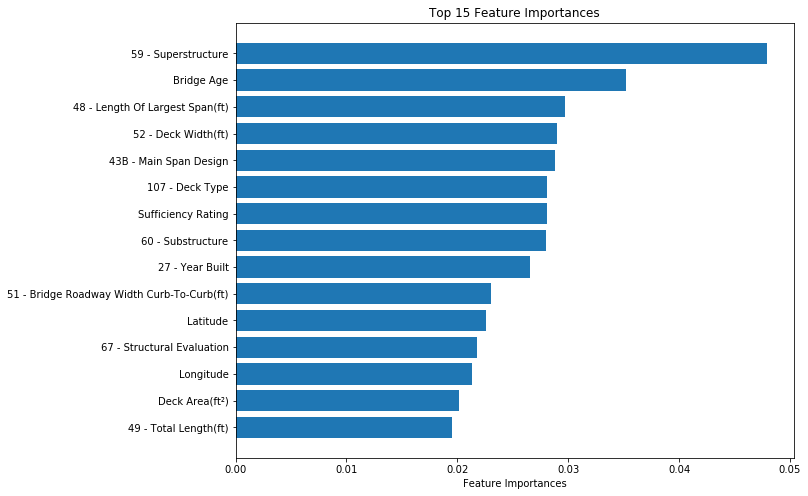

In [13]:
get_feature_importances(top = 15, plot = True)

## Hyper-parameter Tuning
The parameters that will be tuned are n_estimators, criterion, and max_features. 

In [14]:
# get test and train stes
train_X, test_X, train_y, test_y = get_test_train(data, test_size = 0.4, RANDOM_SEED = RANDOM_SEED)

# train classifier
clf_train = train_clf(train_X, train_y)

In [15]:
# create dictionary of tuning parameters
tuning_parameters = {'n_estimators': [10,100,500], 
                     'criterion': ['gini', 'entropy'], 
                     'max_features': [0.1, 0.25, 0.5]}

# get scoring function
#f1_scorer = make_scorer(f1_score)

# use grid search cross validation with f1 scoring to evaluate tuning parameters 
clf_cv = GridSearchCV(clf_train, param_grid=tuning_parameters, n_jobs = 2)

In [16]:
# train the classifier using the training set
clf_cv.fit(train_X, train_y);

# test the trained classifier using test set
clf_cv.score(test_X, test_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': [10, 100, 500], 'criterion': ['gini', 'entropy'], 'max_features': [0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

0.62830012089069143

In [17]:
# print results for best parameter choices
print(f'Best score for training set: {clf_cv.best_score_}')
print(f'Best n_estimators: {clf_cv.best_estimator_.n_estimators}') 
print(f'Best criterion: {clf_cv.best_estimator_.criterion}')
print(f'Best max_features: {clf_cv.best_estimator_.max_features}')

Best score for training set: 0.6196443427620633
Best n_estimators: 500
Best criterion: entropy
Best max_features: 0.25


In [18]:
# train a new classifier with the best tuning parameters
RandomForestClassifier(n_estimators = clf_cv.best_estimator_.n_estimators, 
                       criterion = clf_cv.best_estimator_.criterion,
                       max_features = clf_cv.best_estimator_.max_features).fit(train_X, train_y).score(test_X,test_y)

0.62980150528409318